In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["NCCL_DEBUG"]="WARN"
#os.environ["NCCL_P2P_LEVEL"]="NODE"

In [2]:
import sys
sys.path.append("../../../")

In [3]:
%load_ext autoreload
%autoreload 2

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [4]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.model.vqgan_clean.vqgan import VQGAN
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
import os
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

In [5]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [6]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2022-06-30 06:47:40.597025: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-30 06:47:40.971339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14252 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [7]:
num_workers = len(tf.config.list_physical_devices("GPU"))
batch_size = 16
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = 100
sample_batch_size = 8

In [8]:
cfg = omegaconf.OmegaConf.load(here("configs/kny_image.yaml"))

In [9]:
dataset_length = 52014 # KNY
#dataset_length = 20*10000 # MNIST
num_batch = dataset_length / batch_size

In [10]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], 3))
    element = tf.cast(element, tf.float32) / 255.0
    return element, element

In [11]:
dataset = ImageDataset("../../../data/kny/images_tfrecords").load()
dataset = dataset.shuffle(dataset_length, reshuffle_each_iteration=True).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
train_size = int(dataset_length * 0.2)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [13]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

In [14]:
train_sample_data = next(train_ds
                          .batch(sample_batch_size)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.batch(sample_batch_size).as_numpy_iterator())

In [15]:
train_ds = (train_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

In [16]:
from ganime.utils.callbacks import TensorboardImage, get_logdir

logdir = get_logdir("../../../logs/ganime/vqgan", experiment_name="kny")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_image_callback = TensorboardImage(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_total_loss",
    min_delta=0.0001,
    patience=100,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_total_loss', save_best_only=True, save_weights_only=True)
callbacks = [tensorboard_callback, tensorboard_image_callback, early_stopping, checkpointing]

In [17]:
# train_mean, train_var, train_std = dataset_statistics(train_ds)

In [18]:
from ganime.visualization.images import display_true_pred

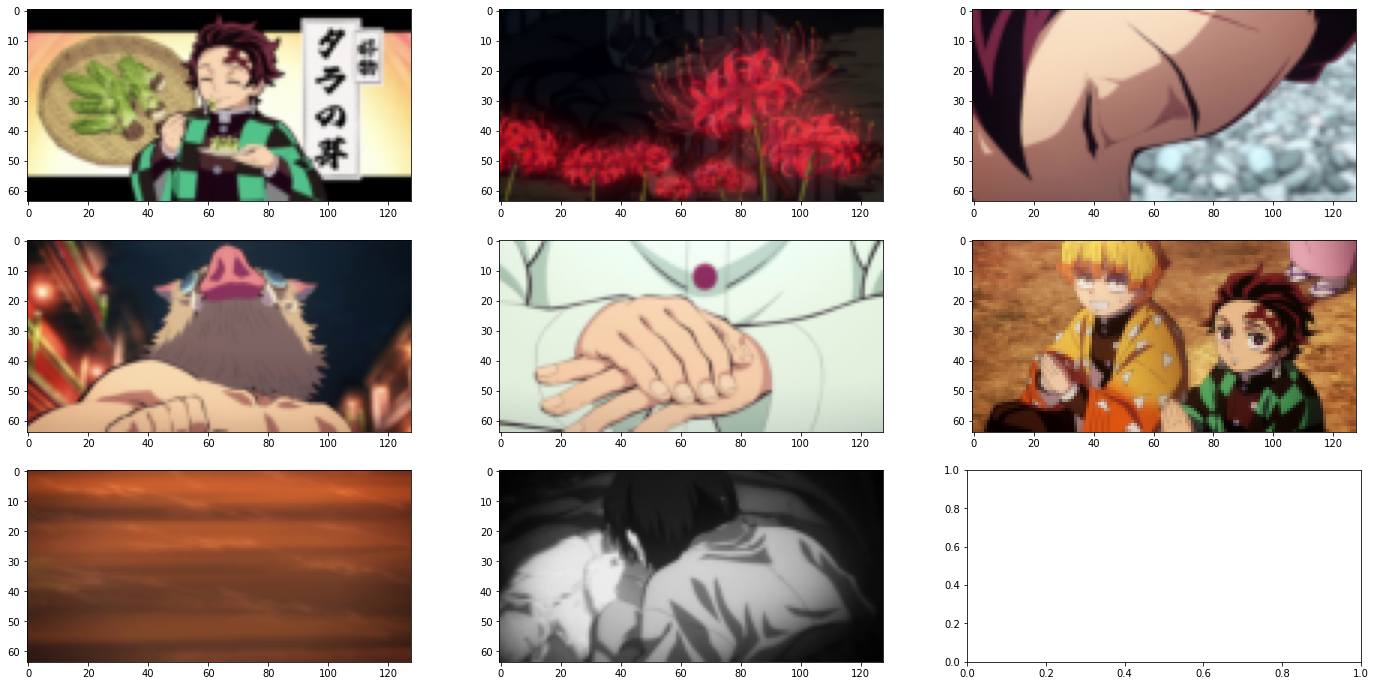

In [19]:
display_images(train_sample_data[0])
plt.show()

In [20]:
with strategy.scope():
    vqgan = VQGAN(**cfg["model"])

Working with z of shape (1, 256, 8, 8) = 16384 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/

In [21]:
with strategy.scope():
    #gen_optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=5e-4))#, clipvalue=1.0, clipnorm=0.5, epsilon=1e-4))
    #disc_optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=5e-5))#, clipvalue=1.0, clipnorm=0.5, epsilon=1e-4))
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    vqgan.compile(gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer)

In [ ]:
history = vqgan.fit(train_ds, validation_data=validation_ds, epochs=300, callbacks=callbacks)

Epoch 1/300


2022-06-30 06:48:10.978326: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-30 06:48:14.209972: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


650/650 [==============================] - 579s 843ms/step - total_loss: 9.9316 - reconstruction_loss: 9.5028 - vq_loss: 0.4289 - disc_loss: 0.0000e+00 - val_total_loss: 9.3048 - val_reconstruction_loss: 9.2789 - val_vq_loss: 0.0259 - val_disc_loss: 0.0000e+00
Epoch 2/300
650/650 [==============================] - 543s 834ms/step - total_loss: 9.1995 - reconstruction_loss: 9.1767 - vq_loss: 0.0229 - disc_loss: 0.0000e+00 - val_total_loss: 9.0958 - val_reconstruction_loss: 9.0761 - val_vq_loss: 0.0198 - val_disc_loss: 0.0000e+00
Epoch 3/300
650/650 [==============================] - 542s 832ms/step - total_loss: 9.0545 - reconstruction_loss: 9.0157 - vq_loss: 0.0389 - disc_loss: 0.0000e+00 - val_total_loss: 8.9254 - val_reconstruction_loss: 8.8339 - val_vq_loss: 0.0914 - val_disc_loss: 0.0000e+00
Epoch 4/300
650/650 [==============================] - 542s 833ms/step - total_loss: 8.8346 - reconstruction_loss: 8.7571 - vq_loss: 0.0775 - disc_loss: 0.0000e+00 - val_total_loss: 8.6654 - va

In [ ]:
x = train_sample_data[0]
generated = vqgan(x[:10])[0]

In [ ]:
display_images(generated)
plt.show()

In [ ]:
display_images(x)
plt.show()

In [ ]:
x2 = train_ds[30][0]
generated2 = vqgan(x2[:10])

In [ ]:
display_images(generated2)
plt.show()

In [ ]:
display_images(x2)
plt.show()